# Prepare matplotlib

In [1]:
import json
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)

# Load data

In [2]:
TICK_LABEL_SIZE = 14
AXIS_LABEL_SIZE = 16

In [3]:
# Functions for loading BLiMP data


def load_blimp_data(path: Path) -> dict:
    with path.open() as f:
        data = json.load(f)
    if "blimp" in data:
        data = data["blimp"]
    return data


def get_uids(data: dict):
    return np.array(list(data["by_uid"].values()))

In [4]:
models = [rf"\texttt{{pico-{t}}}" for t in ("decoder", "relora")]


# Load all BLiMP data
def _get_data():
    for scale in ("tiny", "small"):
        for i in range(0, 20_001, 1_000):
            baseline_data = load_blimp_data(Path(f"blimp_results_{scale}/step_{i}.json"))

            relora_data = load_blimp_data(Path(f"relora-{scale}-eval/step_{i}.json"))

            for mod, data in zip(models, (baseline_data, relora_data)):
                for uid, val in data["by_uid"].items():
                    yield (scale, int(i // 1000), mod, uid, val)


blimp_data = pd.DataFrame(_get_data(), columns=["Scale", "Step", "Model", "UID", "Score"])

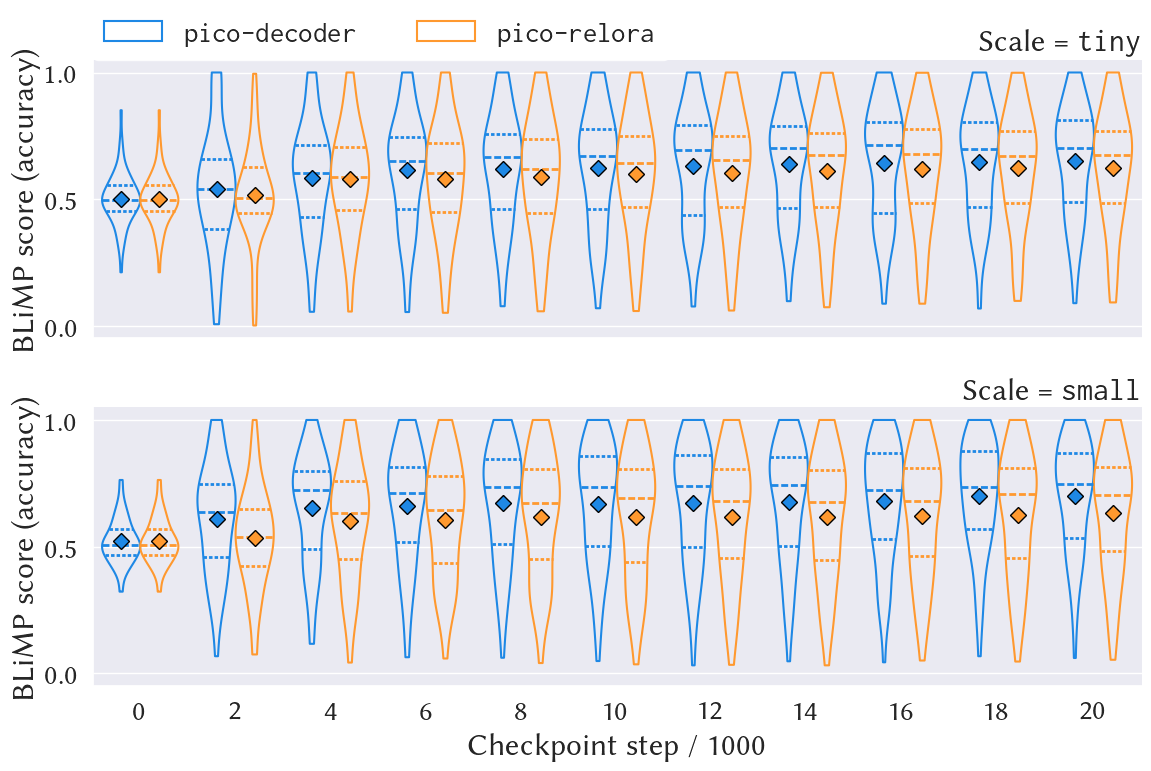

In [10]:
# Create a strip plot using FacetGrid

colors = ["#1E88E5", "#FF992F"]
palette = dict(zip(models, colors))

vio_colors = ["#AED2F4", "#FED9B3"]
vio_palette = dict(zip(models, vio_colors))

dodge = 0.4
size = 8
font_scale = 1.9

sns.set_theme(font_scale=font_scale, rc={"axes.grid": "True", "axes.grid.which": "both"})

g = sns.FacetGrid(
    data=blimp_data[blimp_data["Step"] % 2 == 0],
    row="Scale",
    height=4,
    aspect=3,
    sharey=True,
    margin_titles=False,
)

# g.map_dataframe(
#     sns.boxenplot,
#     x="Step",
#     y="Score",
#     hue="Model",
#     palette=palette,
#     saturation=1,
#     fill=True,
#     dodge=True,
#     zorder=1,
#     k_depth="full",
#     line_kws=dict(linewidth=2),
#     # showmedians=True,
# )

g.map_dataframe(
    sns.violinplot,
    x="Step",
    y="Score",
    hue="Model",
    palette=palette,
    saturation=1,
    fill=False,
    dodge=True,
    inner="quarts",
    # inner_kws=dict(box_width=5, whis_width=0.8),
    inner_kws=dict(linewidth=2),
    cut=0,
    density_norm="count",
    linewidth=None,
    linecolor=None,
    # split=False,
    # inner=None,
)


# Add mean points on top
g.map_dataframe(
    sns.pointplot,
    x="Step",
    y="Score",
    hue="Model",
    palette=palette,
    dodge=dodge,
    marker="D",
    linestyle="none",
    err_kws={"linewidth": 0},
    capsize=0,
    markersize=8,
    markeredgecolor="black",
    # markerfacecolor="lightgray",
    markeredgewidth=1,
    legend=False,
    zorder=5,
)


for i, ax in enumerate(g.axes.flat):
    ax.set_title("")
    if i == 0:
        ax.legend(
            ncols=2,
            bbox_to_anchor=(0, 1),
            loc="lower left",
            facecolor="white",
            edgecolor="white",
            borderaxespad=0,
        )

g.set_titles(row_template=r"Scale = \texttt{{{row_name}}}", loc="right")
g.set_axis_labels("Checkpoint step / 1000", "BLiMP score (accuracy)")

plt.savefig("../graphs/blimp_violin.pdf", bbox_inches="tight")
plt.show()

In [6]:
import scipy.stats as sps

p_vals = []
t_info = []

for grp, grp_data in blimp_data.groupby(["Scale", "Step", "Model"]):
    ckp = grp_data["Score"].to_numpy()
    num_correct = np.sum(ckp * 1000)
    p_val = sps.binom.cdf(num_correct, 67_000, 0.5)
    if num_correct > 67_000 / 2:
        p_val = 1 - p_val
    p_vals.append(min(p_val * 2, 1))
    t_info.append(grp)


adj_ps = sps.false_discovery_control(p_vals)
for p, i in zip(adj_ps, t_info):
    if p >= 1e-10:
        print(i)

('tiny', np.int64(0), '\\texttt{pico-decoder}')
('tiny', np.int64(0), '\\texttt{pico-relora}')
('tiny', np.int64(1), '\\texttt{pico-relora}')
